In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random

sns.set_theme(color_codes=True)
sys.path.insert(0, ".././0.data-download/scripts/")

from matplotlib.pyplot import figure, gcf
from sklearn.decomposition import PCA
from tensorflow import keras

import blitzgsea as blitz
import urllib.request

# Download the gene set library here: https://github.com/MaayanLab/blitzgsea


2023-06-12 15:23:54.475687: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
random.seed(18)
print(random.random())

0.18126486333322134


In [3]:
# list available gene set libraries in Enrichr
blitz.enrichr.print_libraries()

{'LIBRARY_LIST_URL': 'https://maayanlab.cloud/speedrichr/api/listlibs', 'LIBRARY_DOWNLOAD_URL': 'https://maayanlab.cloud/Enrichr/geneSetLibrary?mode=text&libraryName='}
0 - GeneSigDB
1 - Enrichr_Submissions_TF-Gene_Coocurrence
2 - SysMyo_Muscle_Gene_Sets
3 - WikiPathway_2021_Human
4 - HomoloGene
5 - WikiPathways_2013
6 - PFOCR_Pathways_2023
7 - OMIM_Disease
8 - Data_Acquisition_Method_Most_Popular_Genes
9 - Cancer_Cell_Line_Encyclopedia
10 - WikiPathways_2016
11 - WikiPathways_2015
12 - RNAseq_Automatic_GEO_Signatures_Human_Up
13 - Human_Gene_Atlas
14 - KOMP2_Mouse_Phenotypes_2022
15 - Kinase_Perturbations_from_GEO_down
16 - Disease_Signatures_from_GEO_down_2014
17 - Disease_Perturbations_from_GEO_up
18 - Old_CMAP_down
19 - MCF7_Perturbations_from_GEO_up
20 - NIH_Funded_PIs_2017_GeneRIF_ARCHS4_Predictions
21 - PPI_Hub_Proteins
22 - DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019
23 - Disease_Signatures_from_GEO_up_2014
24 - GTEx_Tissue_Expression_Up
25 - L1000_Kinase_and_GPCR_Perturbati

In [4]:
# use enrichr submodule to retrieve gene set library
# these libraries are finicky to work with--they usually work the first time but then may stop working. You may need to remove the library from your computer and trying to reimport it to work again.
library = blitz.enrichr.get_library("GO_Biological_Process_2017")

In [5]:
# load the weight matrix 
gene_weight_dir = pathlib.Path("../2.train-VAE//results/weight_matrix_gsea.csv")
signature = pd.read_csv(gene_weight_dir)
print(signature.shape)
signature.head()

(1000, 101)


,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,GPX4,-0.003431,-0.066462,0.023348,-0.087693,-0.035378,-0.130166,-0.011303,0.002215,0.065100,...,-0.122327,-0.089983,0.008672,-0.032056,-0.070818,-0.042180,-0.043921,0.070101,-0.021080,-0.009599
1,CCND1,0.041190,-0.036413,-0.073804,-0.003457,0.214047,0.094045,-0.096939,-0.046628,0.055162,...,0.073669,0.104024,0.006950,0.009301,0.074342,-0.054289,0.122823,-0.103081,-0.096315,0.040273
2,EP300,0.042926,-0.047306,-0.007981,0.092379,-0.049409,-0.051858,-0.000272,-0.015936,-0.088256,...,-0.071827,-0.009377,0.067449,-0.054565,0.000477,-0.000918,-0.092843,0.085447,-0.072340,0.031898
3,CDK6,0.025111,-0.041455,-0.056006,0.023690,-0.043088,-0.094552,0.011754,-0.006810,-0.007835,...,-0.105212,-0.081106,0.022533,-0.052183,-0.101708,-0.038274,-0.148809,-0.038718,-0.024035,0.003900
4,TXNRD1,0.000167,-0.018388,-0.069532,-0.096174,-0.059824,-0.032566,0.070643,0.013985,-0.008484,...,0.083347,0.030248,0.009382,0.011457,-0.023764,-0.003427,-0.043586,-0.049834,-0.042049,0.007481


In [6]:
all_GSEA_results = []
all_signatures = []
neg_GSEA_results = []
negative_control = []
results = []

range = signature.shape[1]

for col in signature.iloc[:,1:range].columns:
    df = signature.iloc[:,[0,int(col)]]
    result = blitz.gsea(df, library)
    results.append(result)
    all_GSEA_results.append(result.assign(z_dim=f"z_{col}"))
    all_signatures.append(df)
    neg_df = df.copy()
    neg_df[col] = neg_df[col].sample(frac=1).reset_index(drop=True)
    neg_result = blitz.gsea(neg_df, library)
    neg_GSEA_results.append(neg_result.assign(z_dim=f"z_{col}"))
    negative_control.append(neg_df)

In [7]:
# stack up all of the results to be analyzed
all_GSEA_results= pd.concat(all_GSEA_results)
neg_GSEA_results = pd.concat(neg_GSEA_results)

In [8]:
# sort by what you want to evaluate
all_GSEA_results.sort_values(by='pval', ascending = True)
#neg_GSEA_results.sort_values(by='pval', ascending = True)

,es,nes,pval,sidak,fdr,geneset_size,leading_edge,z_dim
Term,,,,,,,,
mitochondrial translational elongation (GO:0070125),0.424326,6.129842,8.796638e-10,2.093600e-07,2.093600e-07,63,"MRPS24,MRPL57,MRPL38,MRPS11,MRPL53,MRPL43,MRPL...",z_85
mitochondrial translational termination (GO:0070126),0.431944,5.944705,2.769552e-09,6.591531e-07,3.295767e-07,62,"MRPS24,MRPL57,MRPL38,MRPL18,MRPS11,MRPL53,MRPS...",z_85
mitochondrial translational elongation (GO:0070125),0.392803,4.721250,2.343991e-06,5.577150e-04,5.578699e-04,63,"MRPS25,MRPL33,MRPL43,MRPL22,MRPL57,MRPL12,MRPL...",z_94
mitochondrial respiratory chain complex I assembly (GO:0032981),-0.694454,-4.657108,3.206828e-06,7.629351e-04,7.632250e-04,35,"NDUFS3,NDUFA11,NDUFA9,NDUFA10,NDUFA5,NDUFS7,ND...",z_53
mitochondrial translational termination (GO:0070126),0.547263,4.618246,3.869966e-06,9.206297e-04,7.517086e-04,62,"MRPL57,MRPL4,MRPL38,MRPS22,MRPL19,MRPS34,MRPL4...",z_79
...,...,...,...,...,...,...,...,...
multicellular organism development (GO:0007275),-0.198081,-0.000000,1.000000e+00,1.000000e+00,1.000000e+00,7,"CDK4,LDB1,CDK2,ZNF217",z_58
transcription initiation from RNA polymerase II promoter (GO:0006367),-0.202909,-0.000000,1.000000e+00,1.000000e+00,1.000000e+00,16,"MED15,MNAT1",z_57
mitotic cell cycle (GO:0000278),-0.196119,-0.000000,1.000000e+00,1.000000e+00,1.000000e+00,14,MYB,z_57


Text(0.5, 1.0, 'Control Gene Set Enrichment Analysis')

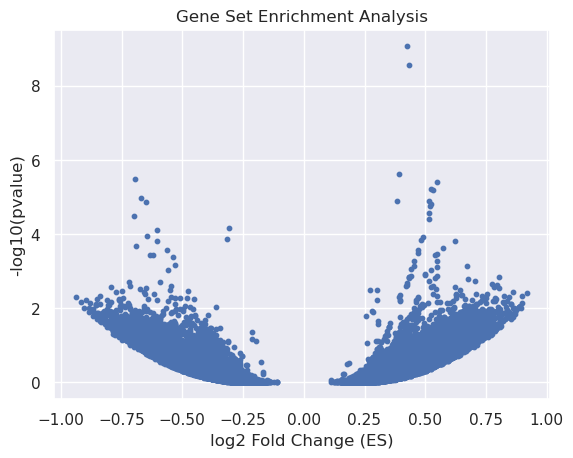

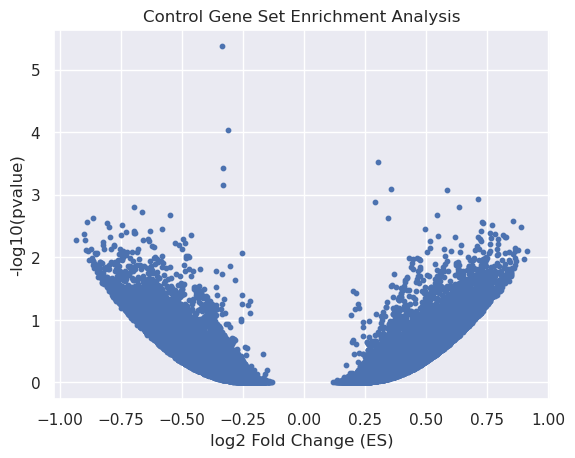

In [9]:
plt.figure()
plt.scatter(x=all_GSEA_results['es'],y=all_GSEA_results['pval'].apply(lambda x:-np.log10(x)),s=10)
plt.xlabel('log2 Fold Change (ES)')
plt.ylabel('-log10(pvalue)')
plt.title('Gene Set Enrichment Analysis')

plt.figure()
plt.scatter(x=neg_GSEA_results['es'],y=neg_GSEA_results['pval'].apply(lambda x:-np.log10(x)), s=10)
plt.xlabel('log2 Fold Change (ES)')
plt.ylabel('-log10(pvalue)')
plt.title('Control Gene Set Enrichment Analysis')

In [10]:
# Using VAE generated data

for df in all_signatures:
    col_titles = df.columns.tolist()
    dim = col_titles[1]
    z_result = results[int(dim)-1]
    
    fig = blitz.plot.running_sum(df, "mitochondrial translational elongation (GO:0070125)", library, result=z_result, compact=False)
    fig.savefig("running_sum_z_" + dim + ".png", bbox_inches='tight')

    fig_compact = blitz.plot.running_sum(df, "mitochondrial translational elongation (GO:0070125)", library, result=z_result, compact=True)
    fig_compact.savefig("running_sum_compact_z_" + dim + ".png", bbox_inches='tight')

    fig_table = blitz.plot.top_table(df, library, z_result, n=15)
    fig_table.savefig("top_table_z_" + dim + ".png", bbox_inches='tight')

# Using negative control

for df in negative_control:
    col_titles = df.columns.tolist()
    dim = col_titles[1]
    z_result = results[int(dim)-1]

    fig = blitz.plot.running_sum(df, "regulation of transcription from RNA polymerase II promoter in response to hypoxia (GO:0061418)", library, result=z_result, compact=False)
    fig.savefig("running_sum_neg_z_" + dim + ".png", bbox_inches='tight')

    fig_compact = blitz.plot.running_sum(df, "regulation of transcription from RNA polymerase II promoter in response to hypoxia (GO:0061418)", library, result=z_result, compact=True)
    fig_compact.savefig("running_sum_compact_neg_z_" + dim + ".png", bbox_inches='tight')

    fig_table = blitz.plot.top_table(df, library, z_result, n=15)
    fig_table.savefig("top_table_neg_z_" + dim + ".png", bbox_inches='tight')


/home/ecohen/anaconda3/lib/python3.10/site-packages/blitzgsea/plot.py:159: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(5,0.5*n), frameon=False)
